In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy as sp
import sdr_utils as sutil
import seaborn as sns
import pandas as pd
from numpy.fft import fft, ifft
from scipy.fft import fft as sfft
from scipy.fft import ifft as sifft
import skrf as rf

In [2]:
samp_rate = 30.72e6    # must be <=30.72 MHz if both channels are enabled
num_samps_tx = 2**18
#num_samps_rx = 2**21
num_samps_rx = 2**21
#num_samps = 2**18      # number of samples per buffer.  Can be different for Rx and Tx
rx_lo = 2.4e9
rx_mode = "manual"  # can be "manual" or "slow_attack"
rx_gain0 = 50
rx_gain1 = 50
tx_lo = rx_lo
tx_gain0 = -40
tx_gain1 = -89

In [3]:
BW = samp_rate / 2 # nyquist
BW = BW/2
BW = 5e6
f_low = 300
f_high = BW - f_low
chirp_duration = 8e-3
dfdt = (f_high - f_low) / chirp_duration
Ts = 1/samp_rate

# generating chirp
t_range = np.arange(0, chirp_duration, Ts)
FM_chirp = signal.chirp(t_range, f_low, chirp_duration, f_high, method = 'linear')


tx_chirp = FM_chirp * 2**14
#shaped = sutil.raised_cos_filter(tx_chirp, β = 0.9)
shaped = tx_chirp
fm_down_chirp = np.flip(shaped)
shaped = np.concatenate([shaped,-1*fm_down_chirp])
I = shaped
Q = np.zeros(len(shaped))
IQ_send = Q + 1j*Q
IQ2 = I + 1j*Q
IQ_send = np.concatenate([IQ2, IQ2, IQ2, IQ2])

TX2_zeros = np.zeros(len(IQ_send))


Text(0, 0.5, 'FFT Amplitude |X(freq)|')

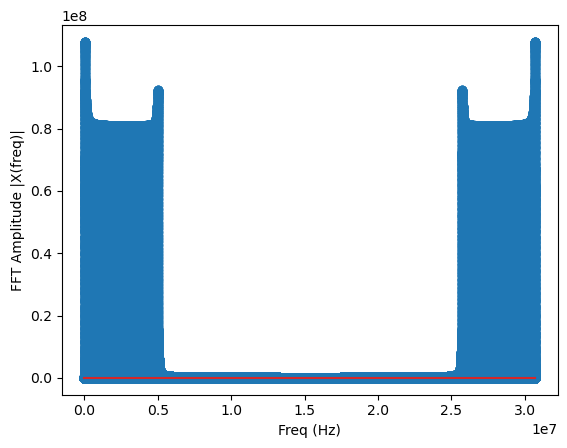

In [4]:
x = IQ_send
sr = samp_rate
X = sfft(x)

N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.stem(freq, np.abs(X))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
#plt.xlim(0, 6e3)

Range = 15.24 m
Range = 50.0 ft
Δt = 50.84 ns
Offset N = 1
Quantized Range = 9.76 m
Quantized Range = 32.02 ft


C:\Users\gowan\anaconda3\envs\SDRR\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


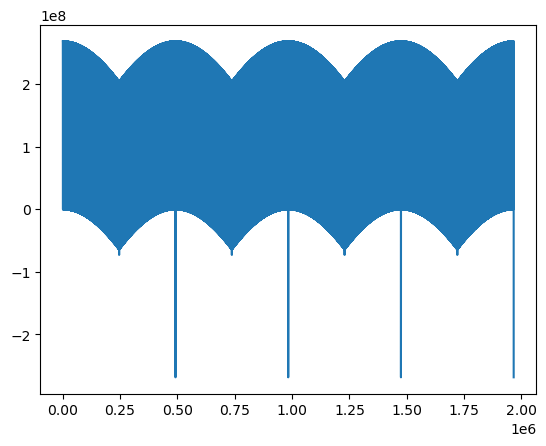

In [5]:
ft_per_m = 3.28084
#R = 10 # meters
R = 50 #ft 
R = R / ft_per_m # convert to meters
print(f"Range = {np.round(R,2)} m")
print(f"Range = {np.round(R*ft_per_m,2)} ft")
t_offset = R / sp.constants.c
print(f"Δt = {np.round(t_offset * 1e9,2)} ns")
# mixing
data_rx_0_h = IQ_send

offset = int(t_offset / Ts)
print(f"Offset N = {offset}")

R_quantized = (offset * Ts) * sp.constants.c
print(f"Quantized Range = {np.round(R_quantized, 2)} m")
print(f"Quantized Range = {np.round(R_quantized*ft_per_m, 2)} ft")


data_rx_1_h = np.concatenate([IQ_send[offset:], IQ_send[:offset]])

mixed = data_rx_0_h * np.conjugate(data_rx_1_h)

plt.plot(mixed)
plt.show()

In [6]:
x = mixed
sr = samp_rate
X = sfft(x)

N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

(0.0, 2000.0)

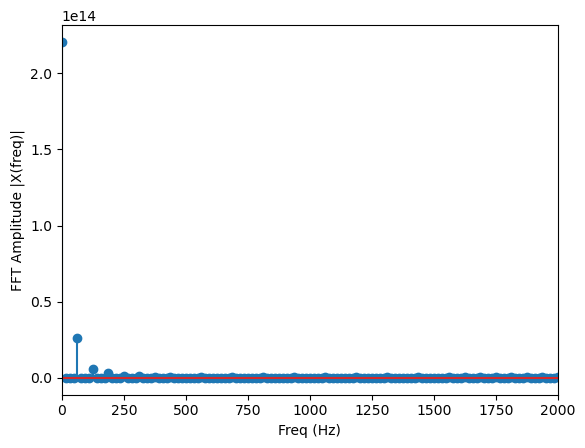

In [7]:
plt.stem(freq, np.abs(X))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 2000)

In [8]:
df_dt = BW / chirp_duration
dielectric_constant = 1
c_new = sp.constants.c / np.sqrt(dielectric_constant)
k_1 = c_new / (2*df_dt)
print(f"k_1 = {np.round(k_1,4)}")

k_1 = 0.2398


In [9]:
# calculating anticipated Δf
Δf_anticipated = R / k_1
print(f"Δf anticipated = {Δf_anticipated} Hz")

Δf anticipated = 63.543958101841305 Hz


In [10]:
# define search range
R0 = 1 # meter
R1 = 1000 # meter

f0 = R0/k_1
f1 = R1/k_1

f0_i = np.abs(freq-f0).argmin()
f1_i = np.abs(freq-f1).argmin()

print(f"Searching from index {f0_i}, {freq[f0_i]} Hz")
print(f"Searching to index {f1_i}, {freq[f1_i]} Hz")

peaks = signal.find_peaks(np.abs(X[f0_i:f1_i]))[0]
Δf = freq[np.abs(X[peaks]).argmax()]
print(np.abs(X[peaks]).argmax())
print(f"shape = {peaks.shape}")
#Δf = peaks[0][peaks[0])]
#Δf = freq[peaks[0][0]]
Δf = Δf
print(f"Δf = {Δf}")
R = (3e8 * np.abs(Δf)) / (2*2*df_dt)
print(f"Range estimate = {np.round(R,2)} m")
print(f"Range estimate = {np.round(R*ft_per_m, 2)} ft")


Searching from index 0, 0.0 Hz
Searching to index 267, 4171.875 Hz
0
shape = (66,)
Δf = 0.0
Range estimate = 0.0 m
Range estimate = 0.0 ft


In [11]:
SMA_50 = rf.Network("./s_parameters/SMA-50ft-2GHz-3GHz.s2p")
SMA_25 = rf.Network("./s_parameters/SMA-25ft-2GHz-3GHz.s2p")
SMA_05 = rf.Network("./s_parameters/SMA-0.5ft-2GHz-3GHz.s2p")
directional_coupler_in_out = rf.Network("./s_parameters/Directional-Coupler-Input-to-Output.s2p")
directional_coupler_in_coupled = rf.Network("./s_parameters/Directional-Coupler-Input-to-Coupled.s2p")

directional_coupler_in_coupled

2-Port Network: 'Directional-Coupler-Input-to-Coupled',  2000000000.0-3000000000.0 Hz, 101 pts, z0=[50.+0.j 50.+0.j]

C:\Users\gowan\anaconda3\envs\SDRR\lib\site-packages\skrf\mathFunctions.py:265: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(z)


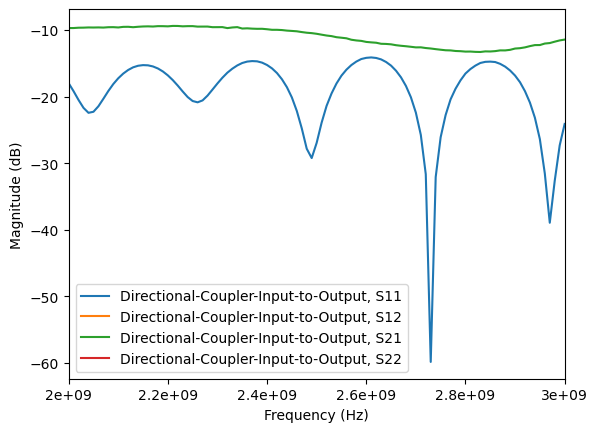

In [12]:
feed_long = directional_coupler_in_out ** SMA_25 # cascade coupler and 25 ft SMA
feed_loopback = directional_coupler_in_coupled ** SMA_05
feed_long.plot_s_db()

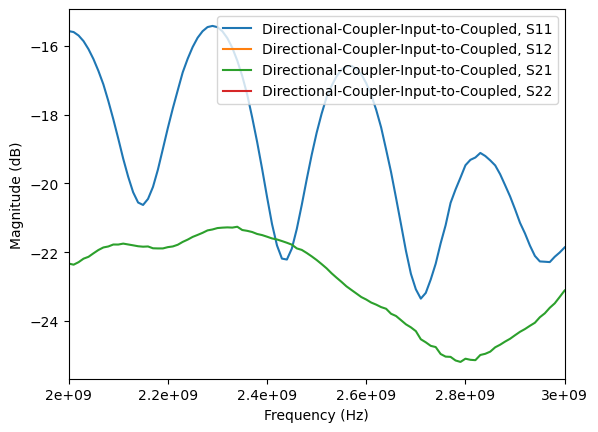

In [13]:
feed_loopback.plot_s_db()

In [14]:
def apply_s21(IQ, rf_network, theta_0):
    global samp_rate
    s21_db = rf_network['2.4-2.405GHz'].s_db[0][1][0]
    s21_deg = rf_network['2.4-2.405GHz'].s_deg[0][1][0]
    print(f"phase shift: {s21_deg} deg")
    Ts = 1/samp_rate
    theta = s21_deg * (np.pi/180)
    #print(f"θ = {theta}")
    t = np.arange(0, Ts*len(IQ_send), Ts)
    #return IQ * 10**(s21_db/10) * np.exp(1j*2*np.pi*s21_deg*t)
    gain = 1
    #gain = 10**(s21_db/10)
    x = sfft(IQ)
    shift = x * np.exp(-1*1j*theta_0)
    IQ_new = sifft(shift)
    return IQ_new * gain
    #return IQ * 10**(s21_db/10) * np.exp(1j*theta)

In [15]:
feed_long_s21_db = feed_long['2.4-2.405GHz'].s_db[0][1][0]
feed_long_s21_deg = feed_long['2.4-2.405GHz'].s_deg[0][1][0]

feed_loopback_s21_db = feed_loopback['2.4-2.405GHz'].s_db[0][1][0]
feed_loopback_s21_deg = feed_loopback['2.4-2.405GHz'].s_deg[0][1][0]


Ts = 1/samp_rate

t = np.arange(0, Ts*len(IQ_send), Ts)
IQ_long = IQ_send * 10**(feed_long_s21_db/10) * np.exp(1j*2*np.pi*feed_long_s21_deg*t)
IQ_loopback = IQ_send * 10**(feed_loopback_s21_db/10) * np.exp(1j*2*np.pi*feed_loopback_s21_deg*t)

phase shift: -85.84348683487318 deg
phase shift: 49.78447203587926 deg


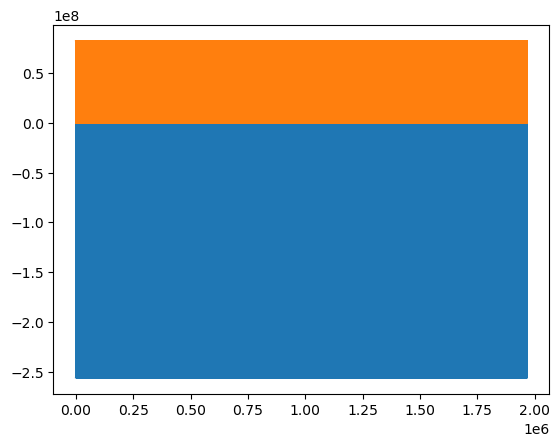

In [16]:
long_75 = directional_coupler_in_out ** SMA_50 ** SMA_25
loopback = directional_coupler_in_coupled ** SMA_05

IQ_long_75 = apply_s21(IQ_send, long_75, 60)
IQ_loopback = apply_s21(IQ_send, loopback, 0)

t = np.arange(0, Ts*len(IQ_send), Ts)
δf = 1e5 # degrees
θ = δf * (np.pi/180)
IQ_rx = IQ_send * np.exp(1j*θ*t)
# mixing
mixed_s_param = IQ_long_75 * np.conjugate(IQ_loopback)

plt.plot(mixed_s_param.real)
plt.plot(mixed_s_param.imag)
plt.show()

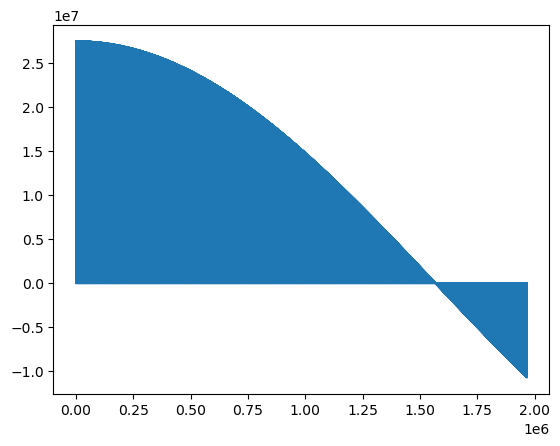

In [18]:
mixed_s_param = IQ_long * np.conjugate(IQ_loopback)

plt.plot(mixed_s_param)
plt.show()

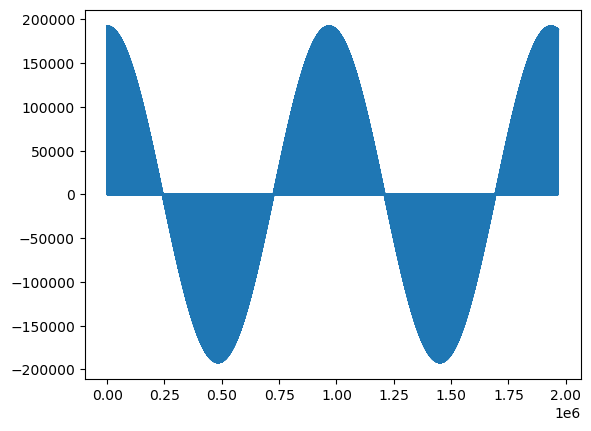

In [31]:
feed_long = directional_coupler_in_out ** SMA_25 # cascade coupler and 25 ft SMA
feed_loopback = directional_coupler_in_coupled ** SMA_05


feed_long_s21_db = feed_long['2.4-2.405GHz'].s_db[0][1][0]
feed_long_s21_deg = feed_long['2.4-2.405GHz'].s_deg[0][1][0]

feed_loopback_s21_db = feed_loopback['2.4-2.405GHz'].s_db[0][1][0]
feed_loopback_s21_deg = feed_loopback['2.4-2.405GHz'].s_deg[0][1][0]


R = 25 #ft 
R = R / ft_per_m # convert to meters
Δf_theoretical = R / 0.24 # update later


Ts = 1/samp_rate

t = np.arange(0, Ts*len(IQ_send), Ts)

feed_long_s21_rad = feed_long_s21_deg * (np.pi/180) * 100
feed_loopback_s21_rad = feed_loopback_s21_deg * (np.pi/180) * 100

IQ_long = IQ_send * 10**(feed_long_s21_db/10) * np.exp(1j*2*np.pi*Δf_theoretical*t)
IQ_loopback = IQ_send * 10**(feed_loopback_s21_db/10)

# IQ_long = IQ_send * 10**(feed_long_s21_db/10) * np.exp(1j*2*np.pi*feed_long_s21_deg*t)
# IQ_loopback = IQ_send * 10**(feed_loopback_s21_db/10) * np.exp(1j*2*np.pi*feed_loopback_s21_deg*t)

mixed_s_param = IQ_long * np.conjugate(IQ_loopback)

plt.plot(mixed_s_param)
plt.show()

(0.0, 2000.0)

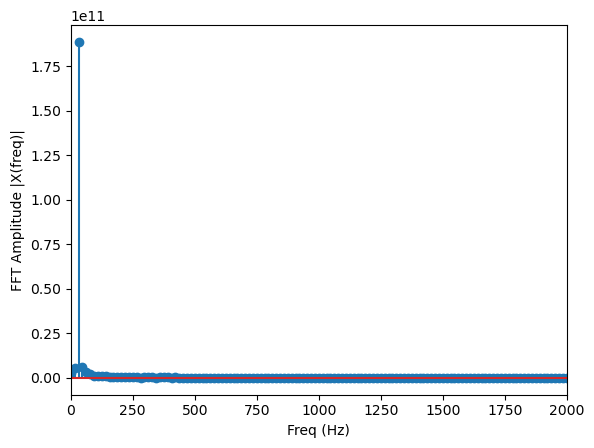

In [32]:
x = mixed_s_param
sr = samp_rate
X = sfft(x)

N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.stem(freq, np.abs(X))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 2000)